FILTER

Filter adalah sistem linier dan tidak bergantung pada waktu. Ini berarti filter memenuhi sifat-sifat berikut:
Jika F(x(n)) adalah fungsi filter dari sinyal input x(n) maka kita memiliki:
- Linieritas: untuk 2 sinyal x1(n) dan x2(n),
F(x1(n) + x2(n)) = F(x1(n)) + F(x2(n))
Dengan faktor a:
F(a⋅x(n))=a⋅F(x(n))
yang berarti kita dapat "mengeluarkan" jumlah dan faktor dari fungsi kita.

- Invarians Waktu: jika y(n) = F(x(n)) maka kita memiliki, untuk penundaan n0 :
y(n+n0)=F(x(n+n0))
yang berarti fungsi kita tetap sama tidak peduli kapan pun kita menerapkannya.

FIR Filters

Filter Finite Impulse Response (FIR) sederhana memiliki persamaan perbedaan seperti berikut ini, dengan x(n) adalah input filter kita, dan y(n) adalah outputnya:
y(n) = ∑ atas L bawah m = 0 b(m) x(n - m)
Perhatikan bahwa ini adalah konvolusi sinyal x(n) dengan b(n). Di sini, b(m) adalah koefisien filter, atau respons impulsnya. Ini biasanya juga disebut sebagai "taps", karena sistem ini dapat dilihat sebagai "mengetuk" garis tunda, seperti yang terlihat pada gambar di bawah ini.

Persamaan perbedaan ini juga merupakan bagaimana biasanya filter diimplementasikan dalam Matlab atau Python dan bahasa pemrograman lainnya. Diagram blok tipikal filter FIR adalah sebagai berikut:

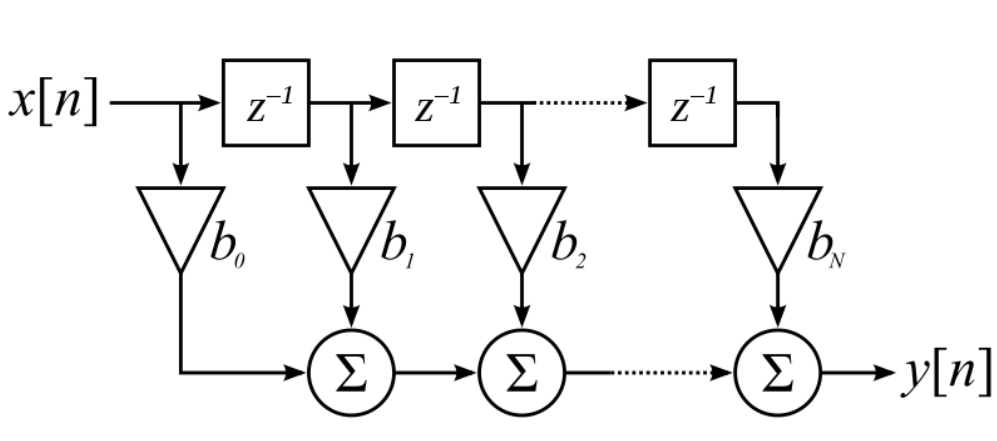

Perhatikan bahwa di sini blok dengan z-1 diimplementasikan dengan penundaan sebesar 1 interval sampling, bukan perkalian dengan z-1 seperti yang kita lakukan pada domain-z!

Setelah blok penundaan pertama z-1 kita memiliki x[n-1]
Setelah blok penundaan kedua kita memiliki x[n-2] dan seterusnya. Setiap blok penundaan "menghafal" nilai dari kiri untuk satu siklus clock sampel, dan melepaskannya ke kanan pada siklus clock sampel berikutnya. Oleh karena itu, mereka menunda sampel sebanyak 1 siklus clock sampel.

Transformasi-z dari persamaan selisih konvolusi kita
y(n) = ∑ atas L bawah m = 0 b(m) x(n - m)

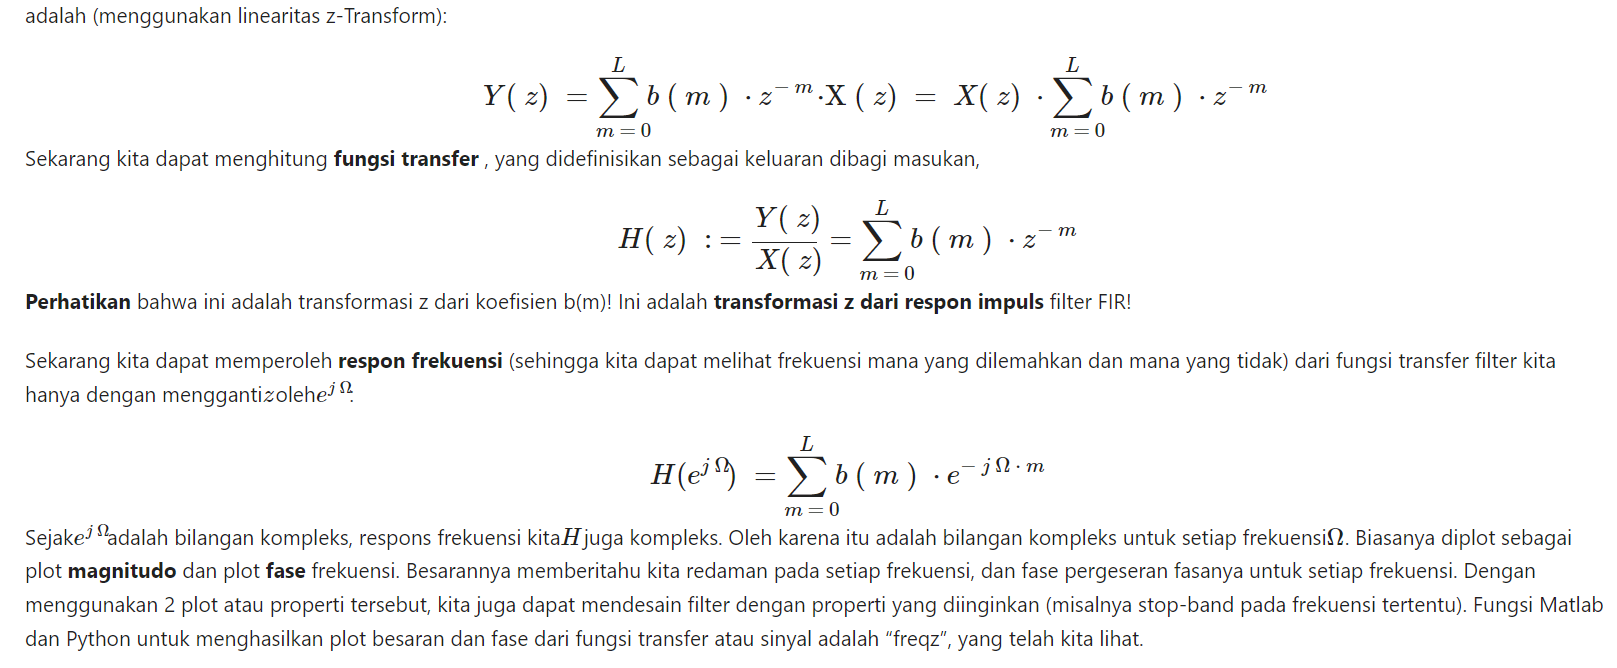


In [ ]:
%pylab inline
#%pylab notebook # for plots editable inthe notebook
#%matplotlib qt # for popout plots
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.fir_design_helper as fir_d
import sk_dsp_comm.iir_design_helper as iir_d
import sk_dsp_comm.multirate_helper as mrh
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

In [ ]:
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

Desain Filter Menggunakan Modul Pembantu
Sinyal paket Scipy membantu dalam mendesain banyak jenis filter digital. Sebagai alternatif, di sini kita mengeksplorasi penggunaan modul desain filter yang terdapat di scikit-dsp-comm (https://github.com/mwickert/scikit-dsp-comm).

Dalam catatan ini kami secara singkat mengeksplorasi penggunaan sk_dsp_comm.fir_design_helper dan sk_dsp_comm.iir_design_helper. Pada contoh-contoh berikutnya, kami mengasumsikan bahwa impor modul-modul ini dilakukan sebagai berikut:

In [ ]:
import sk_dsp_comm.fir_design_helper as fir_d
import sk_dsp_comm.iir_design_helper as iir_d

Fungsi-fungsi dalam modul ini menyediakan antarmuka yang lebih mudah dan lebih konsisten untuk desain klasik finte impulse response (FIR) (fase linier) dan infinite impulse response (IIR). Fungsi-fungsi di dalam modul ini membungkus fungsi scipy.signal dan juga menggabungkan fungsionalitas baru.

Desain Dari Persyaratan Respons Amplitudo
Dengan fir_design_helper dan iir_design_helper, desain dimulai dengan persyaratan respons amplitudo, yaitu frekuensi kritis passband filter, frekuensi kritis stopband, riak passband, dan redaman stopband. Jumlah keran/koefisien (kasus FIR) atau orde filter (kasus IIR) yang diperlukan untuk memenuhi persyaratan ini kemudian ditentukan dan koefisien filter dikembalikan sebagai larik b untuk FIR, dan untuk IIR larik b dan a, serta larik 2D sos bagian orde kedua, dengan baris yang berisi kaskade yang sesuai dengan toplogi bagian orde kedua untuk filter IIR.

Untuk kasus FIR yang kita miliki dalam domain z -domain


HFIR(z)=∑k=0Nbkz−k
dengan ndarray b =  [b0,b1,…,bN]
Untuk kasus FIR yang kita miliki dalam domain z -domain
HIIR(z)=∑Mk=0bkz−k∑Nk=1akz−k=∏k=0Ns−1bk0+bk1z−1+bk2z−21+ak1z−1+ak2z−2=∏k=0Ns−1Hk(z)
dimana  Ns=⌊(N+1)/2⌋
Untuk bentuk b/a, koefisien disusun sebagai :
b = [b0, b1, ..., bM-1], koefisien filter pembilang
a = [a0, a1, ..., aN-1], koefisien filter penyebut
Untuk bentuk sos setiap baris dari larik sos 2D berhubungan dengan koefisien Hk(z) sebagai berikut:

SOS_mat = [[b00, b01, b02, 1, a01, a02], #biquad 0
           [b10, b11, b12, 1, a11, a12], #biquad 1
            .
            .
           [bNs-10, bNs-11, bNs-12, 1, aNs-11, aNs-12]] #biquad Ns-1

Desain Filter FIR Fase Linier

Fokus utama dari modul ini adalah menambahkan kemampuan untuk mendesain filter FIR fase linier dari persyaratan respons amplitudo yang mudah digunakan.
Sebagian besar desain filter digital dimotivasi oleh keinginan untuk mendekati filter yang ideal. Ingatlah bahwa filter yang ideal akan meloloskan sinyal frekuensi tertentu dan memblokir yang lain. Untuk filter analog dan digital, perancang dapat memilih dari berbagai teknik aproksimasi. Untuk filter digital, teknik aproksimasi termasuk dalam kategori IIR atau FIR. Dalam desain filter FIR, dua teknik yang populer adalah memotong respon impuls filter yang ideal dan menerapkan jendela, dan perkiraan equiripple optimal Oppenheim2010. Pendekatan berbasis sampling frekuensi juga populer, tetapi tidak akan dibahas di sini, meskipun scipy.signal mendukung ketiganya. Desain filter umumnya dimulai dengan spesifikasi respons frekuensi yang diinginkan. Respons frekuensi filter dapat dinyatakan dalam beberapa cara, tetapi respons amplitudo adalah yang paling umum, misalnya, menyatakan bagaimana Hc (jΩ) atau H (ejω) = H (ej2πf / fs) harus berperilaku. Desain yang lengkap terdiri dari jumlah koefisien (tap) yang diperlukan dan koefisien itu sendiri (float presisi ganda atau float64 di Numpy, dan float64_t di C). Gambar 1, di bawah ini, menunjukkan persyaratan respons amplitudo dalam hal penguatan filter dan frekuensi kritis untuk filter lowpass, highpass, bandpass, dan bandstop. Frekuensi kritis diberikan di sini dalam hal persyaratan analog dalam Hz. Frekuensi pengambilan sampel diasumsikan dalam Hz. Nilai riak passband dan redaman stopband dalam dB. Perhatikan bahwa redaman dalam dB adalah negatif dari penguatan, misalnya, -60 penguatan stopband setara dengan 60 dB redaman stopband.

In [ ]:
Image('300ppi/FIR_Lowpass_Highpass_Bandpass_Bandstop@300ppi.png',width='90%')

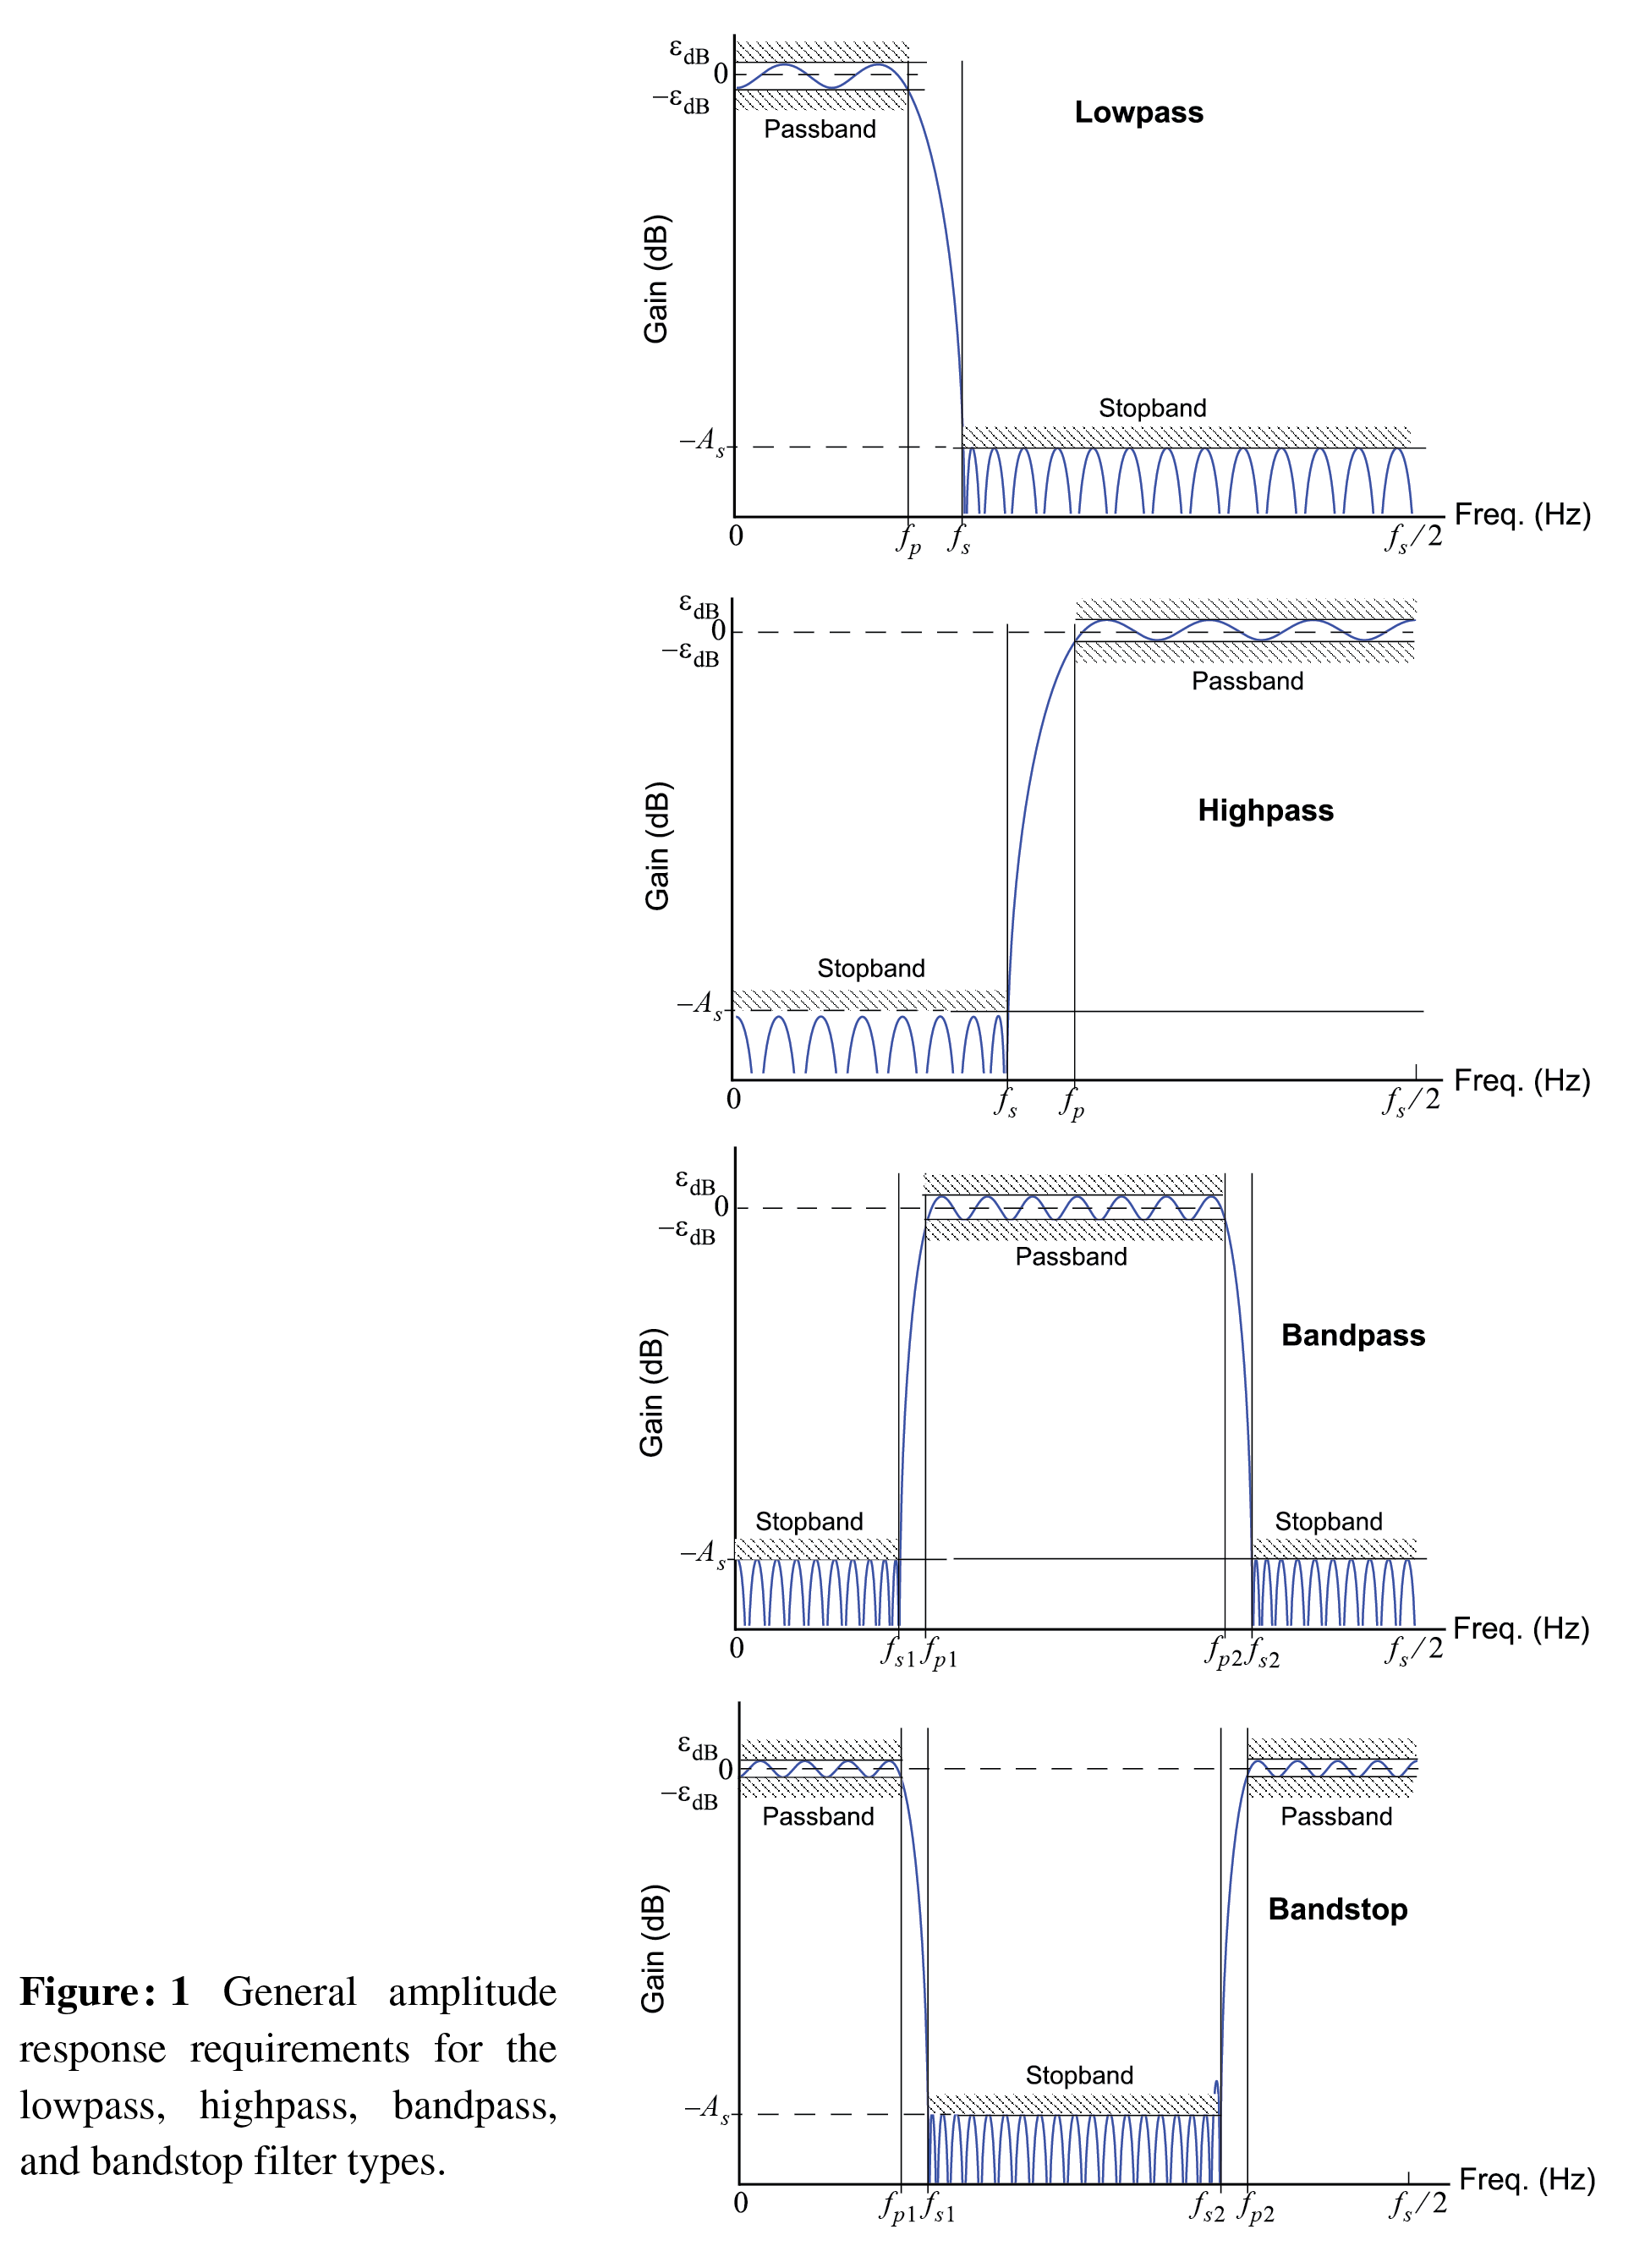

Terdapat 10 fungsi desain filter dan satu fungsi plotting yang tersedia di fir_design_helper.py. Empat fungsi untuk mendesain filter FIR berbasis jendela Kaiser dan empat fungsi untuk mendesain filter FIR berbasis equiripple. Dari delapan fungsi yang baru saja dijelaskan, semuanya menerima persyaratan respons amplitudo dan mengembalikan array koefisien. Dua dari 10 fungsi filter hanyalah pembungkus di sekitar fungsi scipy.signal signal.firwin() untuk mendesain filter dengan urutan tertentu ketika satu (lowpass) atau dua (bandpass) frekuensi kritis diberikan. Fungsi pembungkus memperbaiki jenis jendela ke firwin default hann (hanning). Delapan remamining dijelaskan di bawah ini pada Tabel 1. Fungsi plotting menyediakan cara yang mudah untuk membandingkan respons frekuensi yang dihasilkan dari satu atau lebih desain pada satu plot. Mode tampilan memungkinkan penguatan dalam dB, fase dalam radian, penundaan grup dalam sampel, dan penundaan grup dalam detik untuk laju sampling tertentu. Fungsi ini, freq_resp_list(), berfungsi untuk desain FIR dan IIR. Tabel 1 memberikan detail antarmuka ke delapan fungsi desain di mana d_stop dan d_pass adalah nilai dB positif dan frekuensi kritis memiliki unit yang sama dengan frekuensi sampling fs. Fungsi-fungsi ini tidak menghasilkan hasil yang sempurna sehingga beberapa penyetelan parameter desain mungkin diperlukan, selain menabrak urutan filter ke atas atau ke bawah melalui N_bump.

Contoh Desain

Contoh 1: Lowpass dengan fs = 1 Hz
Untuk filter 31 ketuk ini, kami memilih frekuensi cutoff menjadi Fc = Fs / 8 atau dalam bentuk yang dinormalisasi fc = 1/8.

In [ ]:
Image('300ppi/FIR_Kaiser_Equiripple_Table@300ppi.png',width='80%')


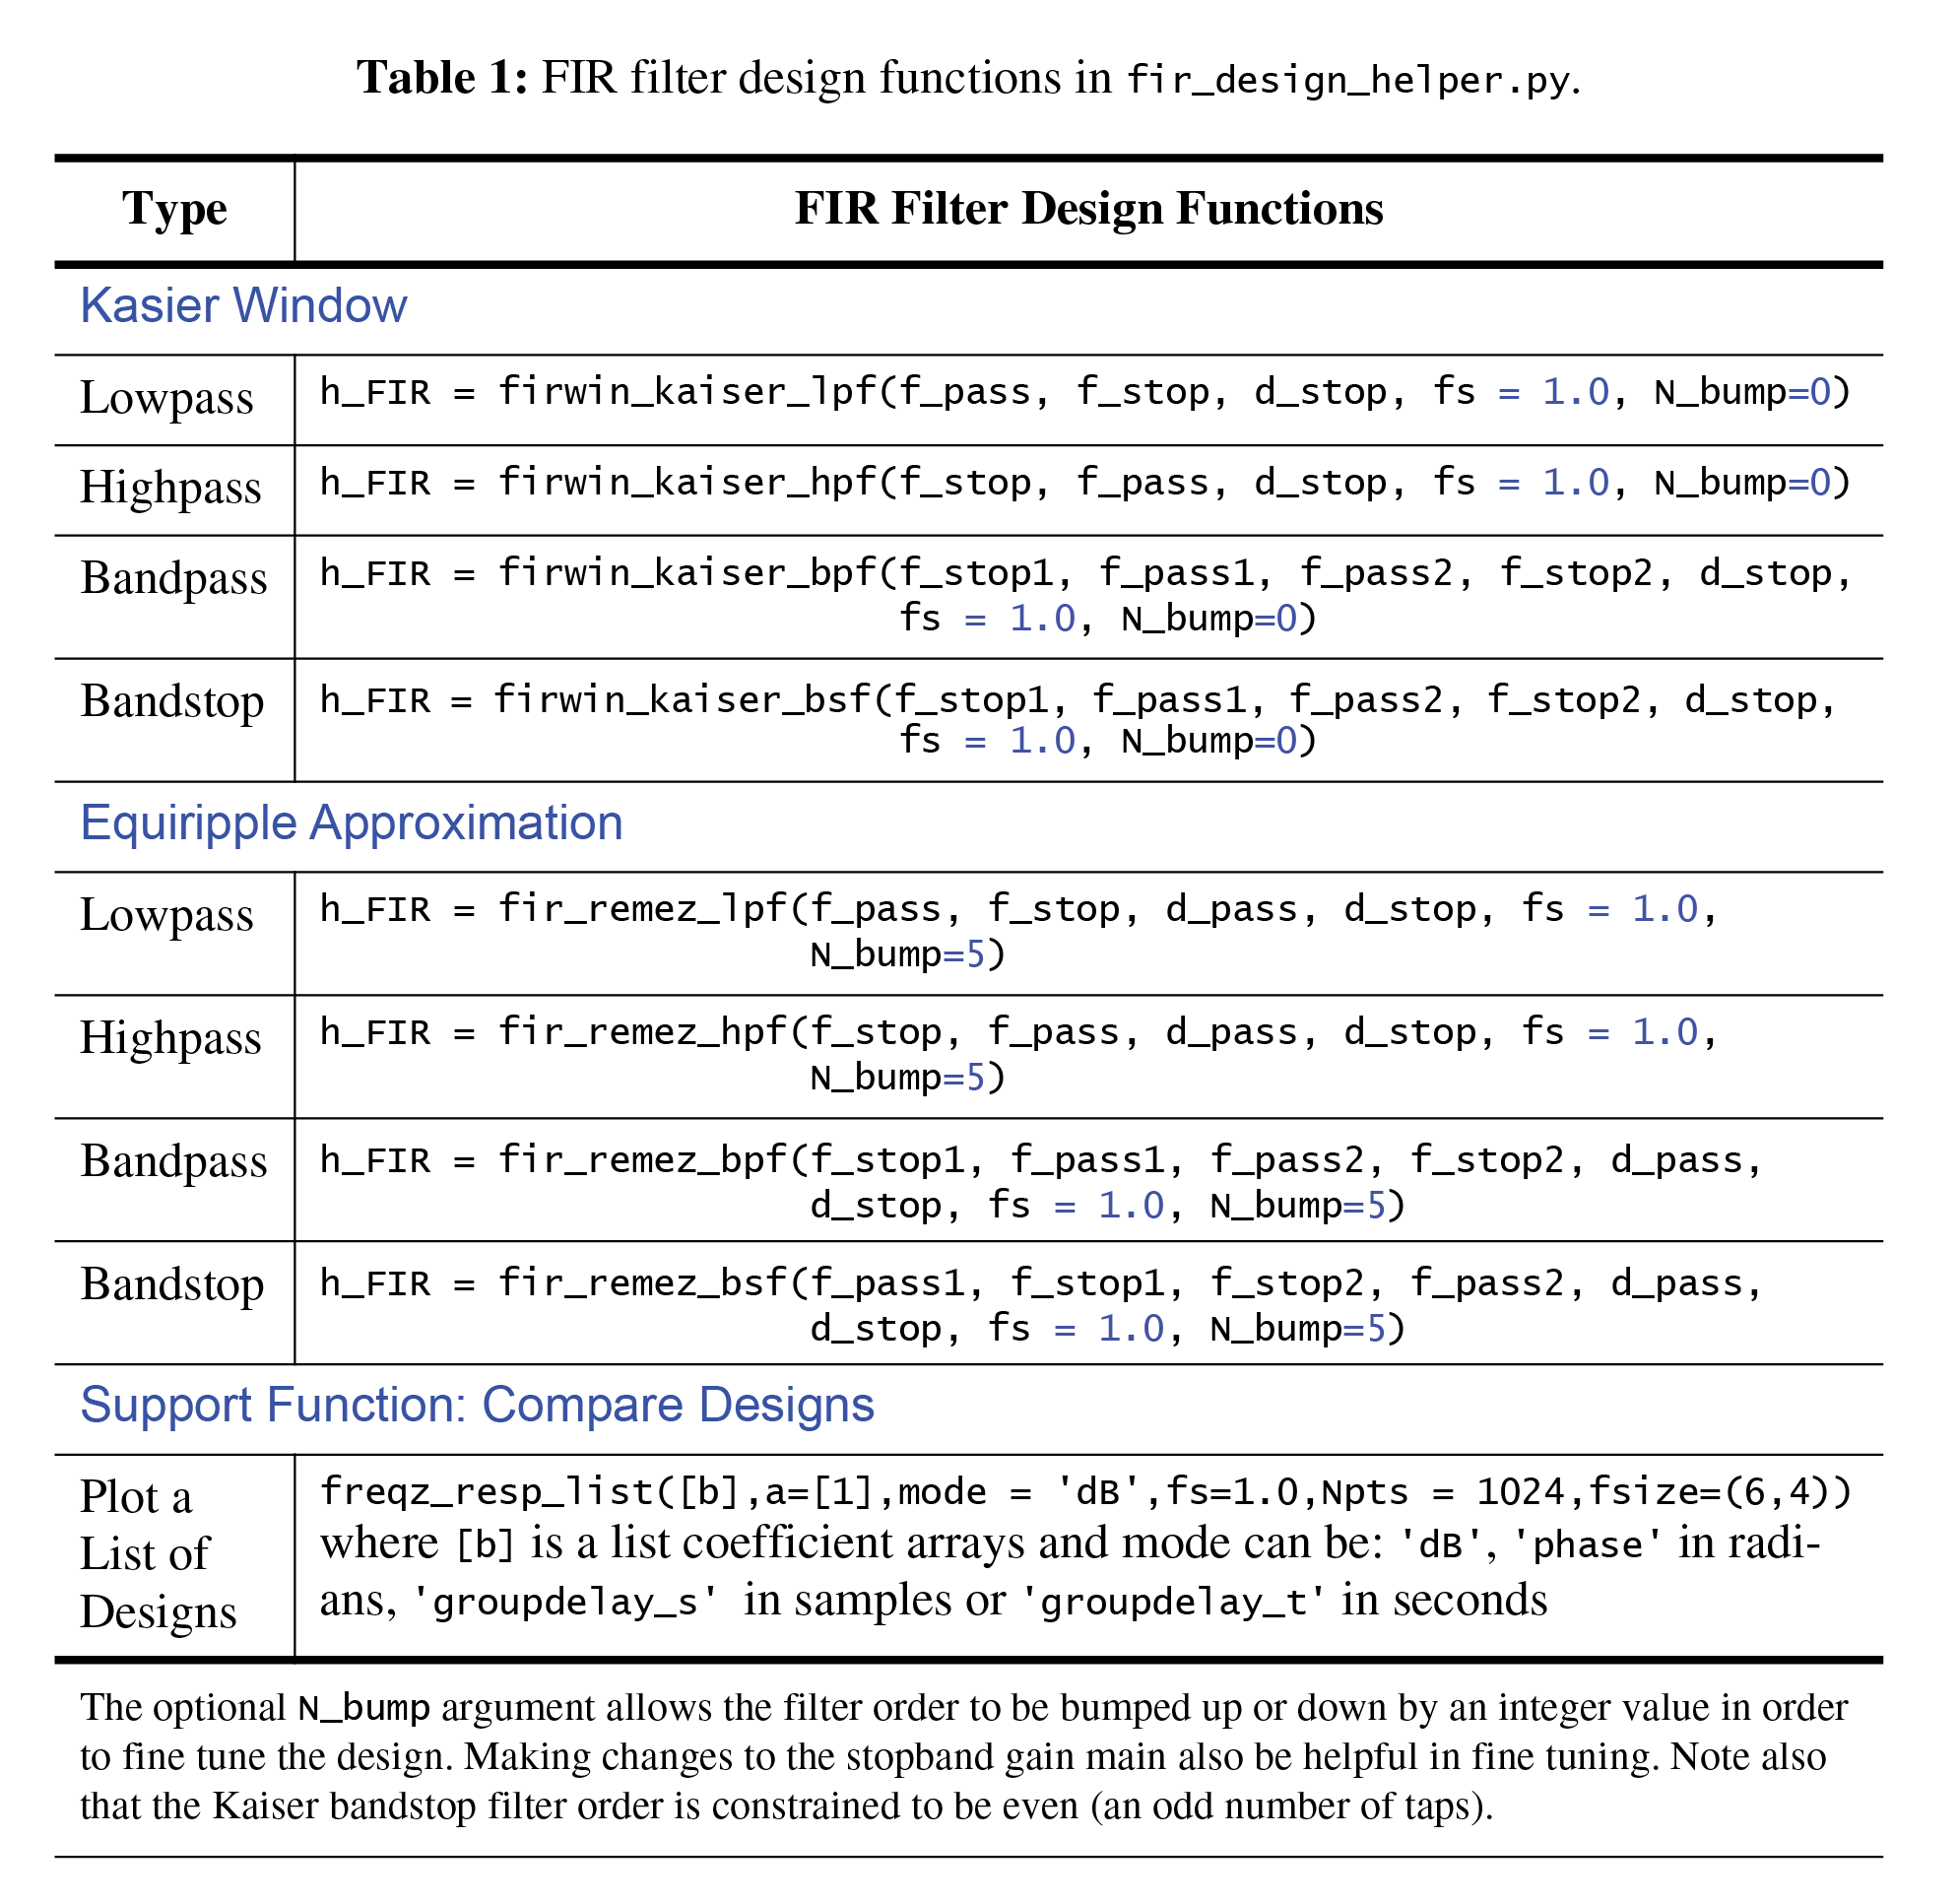

In [ ]:
b_k = fir_d.firwin_kaiser_lpf(1/8,1/6,50,1.0)
b_r = fir_d.fir_remez_lpf(1/8,1/6,0.2,50,1.0)

Kaiser Win filter taps = 72.
Remez filter taps = 53.

In [ ]:
fir_d.freqz_resp_list([b_k,b_r],[[1],[1]],'dB',fs=1)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Lowpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k),r'Remez: %d taps' % len(b_r)),loc='best')
grid();

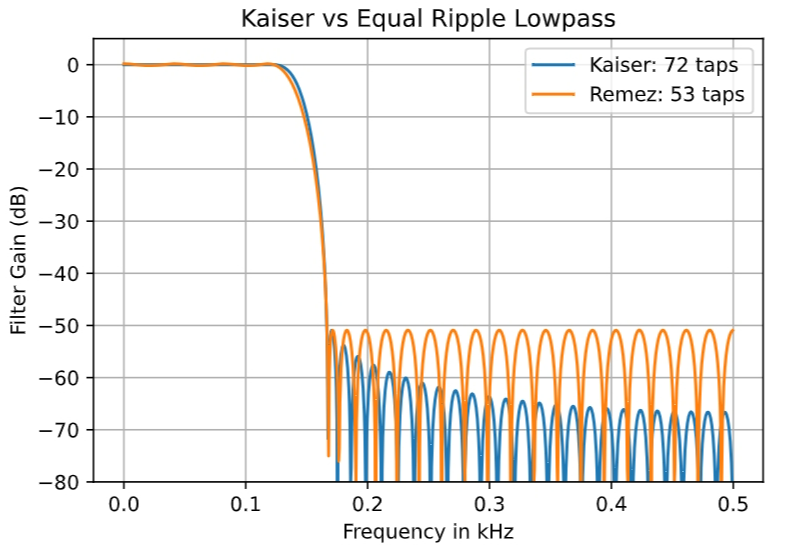

In [ ]:
b_k_bp = fir_d.firwin_kaiser_bpf(7000,8000,14000,15000,50,48000)
b_r_bp = fir_d.fir_remez_bpf(7000,8000,14000,15000,0.2,50,48000)

Kaiser Win filter taps = 142.
Remez filter taps = 101.

In [ ]:
fir_d.freqz_resp_list([b_k_bp,b_r_bp],[[1],[1]],'dB',fs=48)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Bandpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k_bp),
        r'Remez: %d taps' % len(b_r_bp)),
       loc='lower right')
grid();

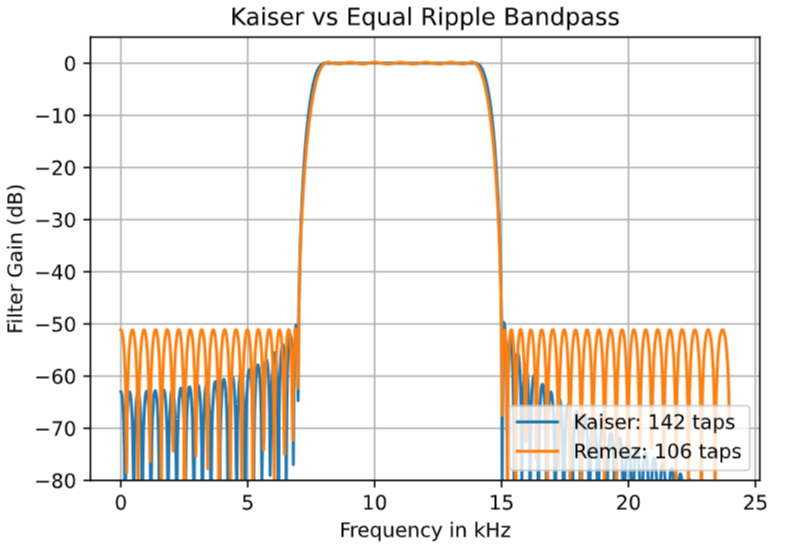

Contoh Desain yang Berguna untuk Interpolasi atau Dekimasi
Di sini kita mempertimbangkan desain lowpass yang perlu melewatkan frekuensi dari [0, 4000] Hz dengan laju sampling 96000 Hz. Skenario ini muncul ketika membangun interpolator menggunakan kelas-kelas dari modul scikit-dps-comm multirate_helper.py untuk meningkatkan laju sampling dari 8000 Hz ke 96000 Hz, atau faktor interpolasi L=12. Perhatikan di bagian atas notebook ini kami juga memiliki impor
import sk_dsp_comm.multirate_helper as mrh
sehingga beberapa fungsionalitas dapat diakses. Untuk detail lebih lanjut tentang penggunaan multirate_helper, lihat.Mulailah dengan desain equalripple yang mempunyai band transisi yang berpusat pada 4000 Hz dengan riak passband 0,5 dB dan redaman stopband 60 dB.

In [ ]:
b_up = fir_d.fir_remez_lpf(3300,4300,0.5,60,96000)

Remez filter taps = 196.

In [ ]:
mr_up = mrh.multirate_FIR(b_up)

FIR filter taps = 196

- Pertimbangkan konfigurasi pole-nol untuk filter orde tinggi ini

In [ ]:
# Take a look at the pole-zero configuration of this very
# high-order (many taps) linear phase FIR
mr_up.zplane()

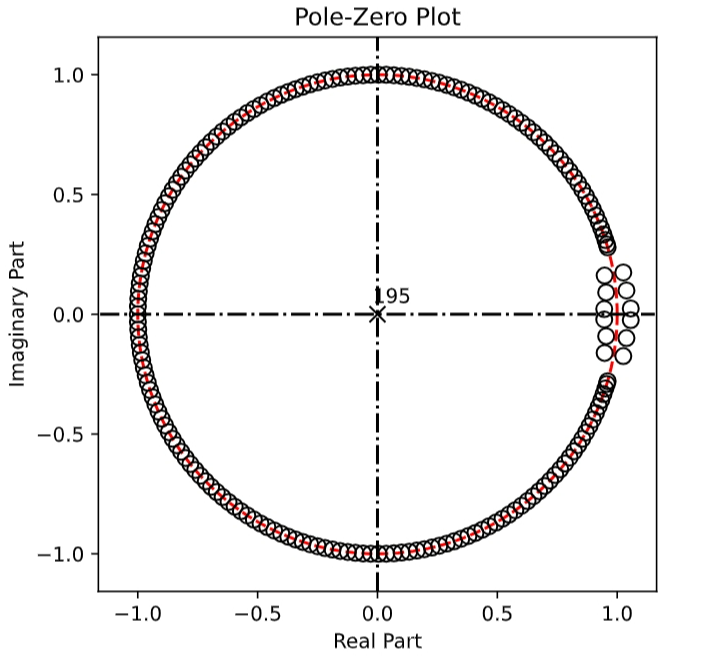

- Lihat keuntungan passband dan stopband

In [ ]:
# Verify the passband and stopband gains are as expected
mr_up.freq_resp('db',96000)

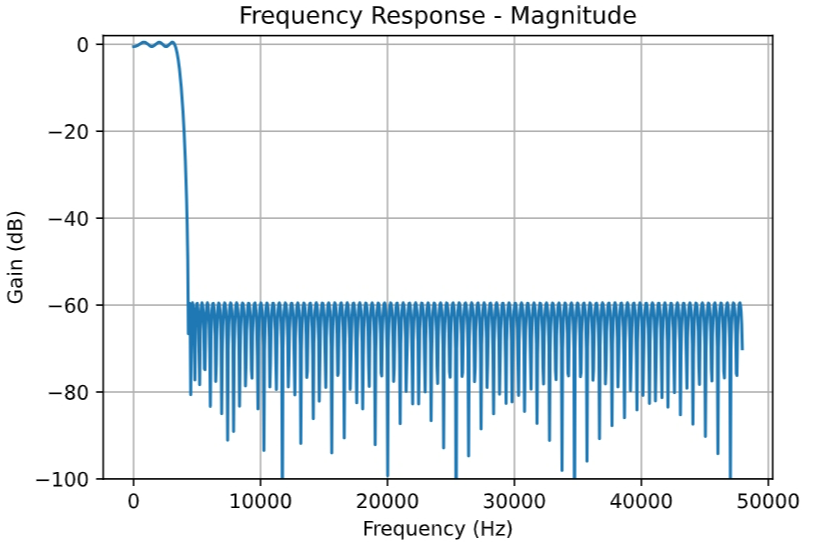

- Lihat bahwa penundaan grup adalah nilai yang diharapkan dari (Ntaps-1)/2=98 sampel

In [ ]:
(len(b_up-1))/2

98.0

In [ ]:
# Verify that the FIR design has constant group delay (N_taps - 1)/2 samples
mr_up.freq_resp('groupdelay_s',96000,[0,100])

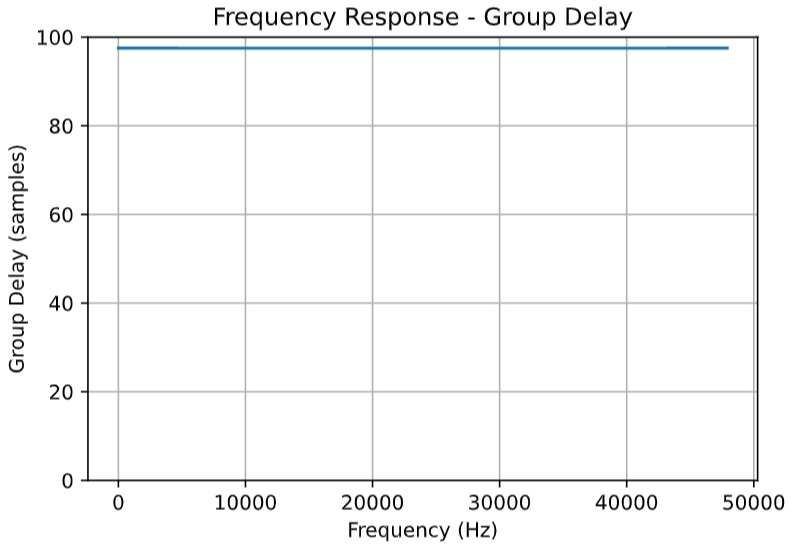